* band pass filter for theta, alpha, beta, and gamma -> single epoch
* compute lcmv
* epochs in source space
* envelope on single epoch
* average envelopes

In [1]:
import mne
import os
import re

os.environ['MNE_3D_OPTION_ANTIALIAS']='false' # to make visualization work

current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

from utils import check_paths

import imageio.v3 as iio


In [ ]:
# create mri dirs in all subs
#! DON'T LAUNCH ANY MORE

subs_path = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects'
subs_dir = os.listdir(subs_path)

for sub_dir in subs_dir:
    if 'sub' in sub_dir:
        path = os.path.join(subs_path, sub_dir, 'mri')
        os.mkdir(path)


In [3]:
# directories to work with
subjects_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects'
mris_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\mri'
fsaverage_src_path = os.path.join(mris_dir, 'fsaverage', 'bem', 'fsaverage-ico-5-src.fif')

In [ ]:
# fetch and update fsaverage
#! DON'T LAUNCH ANY MORE
fs_ave = mne.datasets.fetch_fsaverage(subjects_dir=mris_dir)

In [2]:
# directories to work with
subjects_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects'
mris_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\mri'

for subject in os.listdir(subjects_dir):
    subject_path = os.path.join(subjects_dir, subject)
    # mri_path = os.path.join(mris_dir, subject)
    trans_path = os.path.join(mris_dir, subject, f'{subject}_trans')
    epochs_dir = os.path.join(subject_path, 'epochs')
    epochs_path = os.path.join(epochs_dir, os.listdir(epochs_dir)[0])
    # epochs = mne.read_epochs(epochs_path)
    # trans = mne.read_trans(trans_path)


In [4]:
# dirs to test SR on single subject
subject = 'sub2'
subject_dir = os.path.join(subjects_dir, subject)
# mri_path = os.path.join(mris_dir, subject)
epochs_dir = os.path.join(subject_dir, 'epochs')
epochs_path = os.path.join(epochs_dir, os.listdir(epochs_dir)[0])
trans_path = os.path.join(mris_dir, subject, f'{subject}_trans')

# print(subject_dir, mris_dir, epochs_dir, epochs_path, trans_path, sep='\n')


In [5]:
# read epochs and trans files
epochs = mne.read_epochs(epochs_path)
info = epochs.info
trans = mne.read_trans(trans_path)

Reading D:\Ekaterina_Voevodina\memory_formation\data\subjects\sub2\epochs\enc_epochs.fif ...
    Found the data of interest:
        t =   -1500.00 ...    3995.00 ms
        0 CTF compensation matrices available


C:\Users\CCDM\AppData\Local\Temp\ipykernel_4988\52449833.py:2: RuntimeWarning: This filename (D:\Ekaterina_Voevodina\memory_formation\data\subjects\sub2\epochs\enc_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_path)


Not setting metadata
210 matching events found
No baseline correction applied
0 projection items activated


In [6]:
# set frequency bands

evoked_theta = epochs.pick_types(meg='mag').filter(4., 8.).average()
# evoked_alpha = epochs.pick_types(meg='mag').filter(8., 15.).average()
# evoked_beta = epochs.pick_types(meg='mag').filter(15., 30.).average()
# evoked_gamma = epochs.pick_types(meg='mag').filter(30., 60.).average()

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 331 samples (1.655 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 21420 out of 21420 | elapsed:    3.8s finished


In [ ]:
# visualize evoked
#! DON'T ADD TO THE FINAL SCRIPT

evoked_theta.copy().crop(-0.5, 1.5).plot_joint()
evoked_alpha.copy().crop(-0.5, 1.5).plot_joint()
evoked_beta.copy().crop(-0.5, 1.5).plot_joint()
evoked_gamma.copy().crop(-0.5, 1.5).plot_joint()

In [7]:
# create source space
src = mne.setup_source_space(
    subject, spacing='oct6', add_dist='patch',
    subjects_dir=mris_dir)
print(src)

Setting up the source space with the following parameters:

SUBJECTS_DIR = D:\Ekaterina_Voevodina\memory_formation\data\mri
Subject      = sub2
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading D:\Ekaterina_Voevodina\memory_formation\data\mri\sub2\surf\lh.white...
Mapping lh sub2 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\Ekaterina_Voevodina\memory_formation\data\mri\sub2\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/158411 selected to source space (oct = 6)

Loading D:\Ekaterina_Voevodina\memory_formation\data\mri\sub2\surf\rh.white...
Mapping rh sub2 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\Ekaterina_Voevodina\memory_formation\data\mri\sub2\surf\rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 4098/151372 selected to source sp

In [ ]:
# visualize BEM surfaces
#! DON'T ADD TO THE FINAL SCRIPT

plot_bem_kwargs = dict(
    subject=subject, subjects_dir=mris_dir,
    brain_surfaces='white', orientation='coronal')

mne.viz.plot_bem(src=src, **plot_bem_kwargs)


In [11]:
# visualization of sources in 3d
#! DON'T ADD TO THE FINAL SCRIPT

fig = mne.viz.plot_alignment(subject=subject, subjects_dir=mris_dir,
                             surfaces='white', coord_frame='mri',
                             src=src)
mne.viz.set_3d_view(fig, azimuth=173.78, elevation=101.75,
                    distance=0.30, focalpoint=(-0.03, -0.01, 0.03))


In [8]:
# create BEM model

model = mne.make_bem_model(subject=subject, ico=4, #? ico downsampling
                           conductivity=[0.3], # for single layer - suitable for MEG data
                           subjects_dir=mris_dir)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is  -0.87 -19.58  35.45 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


In [9]:
# compute the leadfield matrix / forward operator

fwd = mne.make_forward_solution(info, trans=trans, src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=None,
                                verbose=True)
print(fwd)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=158411, n_used=4098>, <surface (rh), n_vertices=151372, n_used=4098>] MRI (surface RAS) coords, subject 'sub2', ~28.4 MB>
MRI -> head transform : instance of Transform
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999479 -0.032275 -0.000017       1.68 mm
     0.031390  0.971958  0.233051      19.46 mm
    -0.007505 -0.232930  0.972465      18.91 mm
     0.000000  0.000000  0.000000       1.00

Read 102 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000      45.00 mm
     0.000000  0.000000  0.000000  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found    0/2883 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1919.7 ms
    4 source space point omitted because of the    5.0-mm distance limit.
    Computing patch statistics...
    Patch information added...
Checking surface interior status for 4098 points...
    Found 1286/4098 points inside  an interior sphere of radius   46.8 mm
    Found    0/4098 points outside an exterior sphere of radius   92.5 mm
    Found    0/2812 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found    0/2812 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1941.8 ms

Checking surface interior status for 102 points...
    Found   0/102 points inside  an interior sphere of radius   46.8 mm
    Found 102/102 points outside an exterior sphere of radius   92.5 mm
    Found   0/  0 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found   0/  0 points outside using solid angles
    Total 0/102 points inside the surface
Interior check completed in 234.2 ms
Setting up compensation data...
    No compensation set. Nothing more to do.

Composing the field computation matrix...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Computing MEG at 8192 source locations (free orientations)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished



Finished.
<Forward | MEG channels: 102 | EEG channels: 0 | Source space: Surface with 8192 vertices | Source orientation: Free>


In [ ]:
# check number of vertices
#! DON'T ADD TO THE FINAL SCRIPT

print(f'Before: {src}')
print(f'After:  {fwd["src"]}')

# numpy array containing gain matrix
leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

In [ ]:
# numpy array containing the forward operator corresponding to the source space
#! DON'T ADD TO THE FINAL SCRIPT

fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)
leadfield = fwd_fixed['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

In [ ]:
# save forward solution
#? How to set the path?

fwd_save = mne.write_forward_solution('forward_solution.fif', fwd_fixed, overwrite=False) #?

# mne.read_forward_solution(fname, include=(), exclude=(), verbose=None) to read the fwd solution file

In [ ]:
#! DON'T ADD TO THE FINAL SCRIPT

mne.viz.plot_alignment(info, trans, subject=subject, dig=True,
                       meg=['helmet', 'sensors'], subjects_dir=mris_dir,
                       surfaces='head-dense')

Computing rank from data with rank=None
    Using tolerance 3.6e-09 (2.2e-16 eps * 102 dim * 1.6e+05  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors
Reducing data rank from 102 -> 102
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 62790
[done]


C:\Users\CCDM\AppData\Local\Temp\ipykernel_4988\3145947965.py:3: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=1.5,


Computing rank from covariance with rank=None
    Using tolerance 9.2e-15 (2.2e-16 eps * 102 dim * 0.41  max singular value)
    Estimated rank (mag): 80
Found multiple SSS records. Using the first.
    MAG: rank 80 computed from 102 data channels with 0 projectors


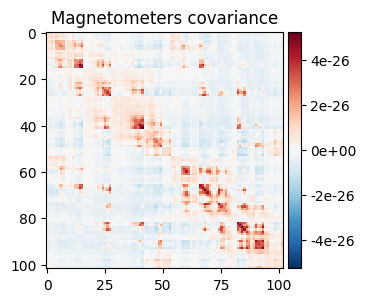

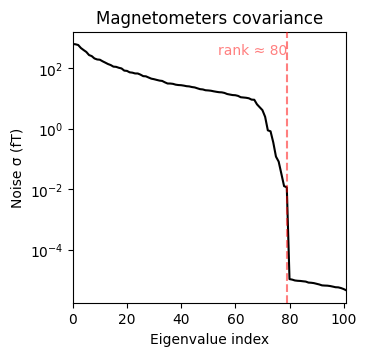

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [10]:
# compute data covariance

data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=1.5,
                                  method='empirical')
data_cov.plot(epochs.info)


Computing rank from data with rank=None
    Using tolerance 2.4e-09 (2.2e-16 eps * 102 dim * 1.1e+05  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors
Reducing data rank from 102 -> 102
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 31710
[done]
Computing rank from covariance with rank=None
    Using tolerance 8.3e-15 (2.2e-16 eps * 102 dim * 0.37  max singular value)
    Estimated rank (mag): 80
Found multiple SSS records. Using the first.
    MAG: rank 80 computed from 102 data channels with 0 projectors


C:\Users\CCDM\AppData\Local\Temp\ipykernel_4988\1256781823.py:3: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  noise_cov = mne.compute_covariance(epochs, tmin=3., tmax=3.75,


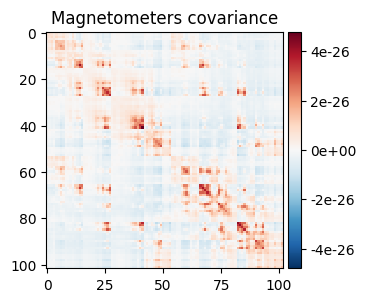

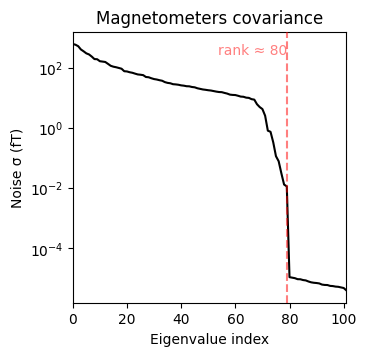

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [11]:
# compute noise covariance from epochs (post-stimulus)

noise_cov = mne.compute_covariance(epochs, tmin=3., tmax=3.75,
                                   method='empirical')
noise_cov.plot(epochs.info)


Computing rank from data with rank=None
    Using tolerance 2.7e-09 (2.2e-16 eps * 102 dim * 1.2e+05  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors
Reducing data rank from 102 -> 102
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 41790
[done]


C:\Users\CCDM\AppData\Local\Temp\ipykernel_7608\649421287.py:3: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  noise_cov = mne.compute_covariance(epochs, tmin=-1., tmax=-0.01,


Computing rank from covariance with rank=None
    Using tolerance 7.8e-15 (2.2e-16 eps * 102 dim * 0.34  max singular value)
    Estimated rank (mag): 80
Found multiple SSS records. Using the first.
    MAG: rank 80 computed from 102 data channels with 0 projectors


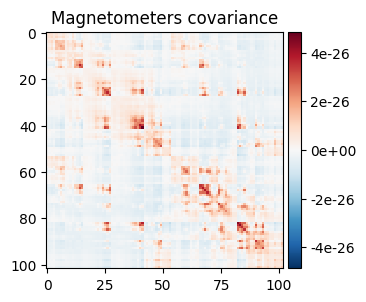

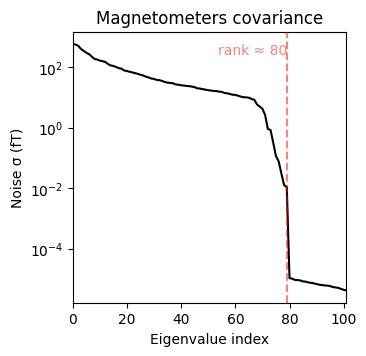

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [10]:
# compute noise covariance from epochs (pre-stimulus)

noise_cov = mne.compute_covariance(epochs, tmin=-1., tmax=-0.01,
                                   method='empirical')
noise_cov.plot(epochs.info)

Opening raw data file D:\Ekaterina_Voevodina\memory_formation\data\empty_room\empty_room_tsss.fif...
Isotrak not found
    Range : 45000 ... 329999 =     45.000 ...   329.999 secs
Ready.
Reading 0 ... 284999  =      0.000 ...   284.999 secs...


C:\Users\CCDM\AppData\Local\Temp\ipykernel_13264\3144208606.py:3: RuntimeWarning: This filename (D:\Ekaterina_Voevodina\memory_formation\data\empty_room\empty_room_tsss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  empty_room_file =  mne.io.read_raw_fif(empty_room_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 95.00 Hz)
- Filter length: 1321 samples (6.605 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)



[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Using up to 1425 segments


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    0.2s finished


Number of samples used : 57000
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.7e-15 (2.2e-16 eps * 102 dim * 0.075  max singular value)
    Estimated rank (mag): 68
Found multiple SSS records. Using the first.
    MAG: rank 68 computed from 102 data channels with 0 projectors


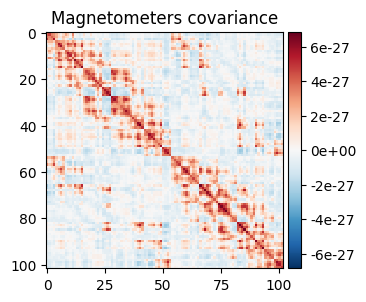

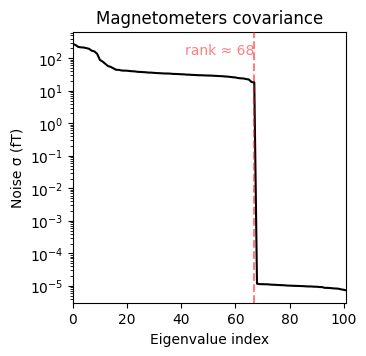

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [10]:
# compute noise covariance from empty room
empty_room_path = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\empty_room\\empty_room_tsss.fif'
empty_room_file =  mne.io.read_raw_fif(empty_room_path, preload=True)
empty_room_file = empty_room_file.resample(200)


empty_room_filt = empty_room_file.copy()\
    .filter(l_freq=.5, h_freq=90)\
    .notch_filter(50) # filter data

noise_cov = mne.compute_raw_covariance(
    empty_room_filt, tmin=0, tmax=None)
noise_cov.plot(epochs.info)

In [12]:
# compute spatial LCMV filter

# part of the epoch is used for noise covariance
filters = mne.beamformer.make_lcmv(evoked_theta.info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)

Computing rank from covariance with rank=None
    Using tolerance 9.2e-15 (2.2e-16 eps * 102 dim * 0.41  max singular value)
    Estimated rank (mag): 80
    MAG: rank 80 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 8.3e-15 (2.2e-16 eps * 102 dim * 0.37  max singular value)
    Estimated rank (mag): 80
    MAG: rank 80 computed from 102 data channels with 0 projectors
Making LCMV beamformer with rank {'mag': 80}
Computing inverse operator with 102 channels.
    102 out of 102 channels remain after picking
Selected 102 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 80}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8192 sources
Filter computation complete


In [19]:
# compute spatial LCMV filter

# part of the epoch is used for noise covariance
# filters = mne.beamformer.make_lcmv(evoked_theta.info, fwd, data_cov, reg=0.05,
#                     noise_cov=noise_cov, pick_ori='max-power',
#                     weight_norm='unit-noise-gain', rank=None)

# in case empty room is used for noise covariance
filters = mne.beamformer.make_lcmv(evoked_theta.info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank='info', reduce_rank=True)

# reg=0.05 loading the diagonal of the covariance matrix with 5% of the sensor power

Computing rank from covariance with rank='info'
    MAG: rank 102 after 0 projectors applied to 102 channels
Computing rank from covariance with rank='info'
    MAG: rank 102 after 0 projectors applied to 102 channels
Making LCMV beamformer with rank {'mag': 102}
Computing inverse operator with 102 channels.
    102 out of 102 channels remain after picking
Selected 102 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 102}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8192 sources
Filter computation complete


In [13]:
# apply spatial LCMV filter to evoked data
stc = mne.beamformer.apply_lcmv(evoked_theta, filters)

In [14]:
stc_hits = mne.beamformer.apply_lcmv(epochs['hits'].filter(4., 8.).average(), filters) # dipoles x time for condition 1
stc_miss = mne.beamformer.apply_lcmv(epochs['miss'].filter(4., 8.).average(), filters) # dipoles x time for condition 2
stc_diff = stc_hits - stc_miss

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 331 samples (1.655 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 331 samples (1.655 sec)



[Parallel(n_jobs=1)]: Done 13260 out of 13260 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 8160 out of 8160 | elapsed:    1.4s finished


In [15]:
lims = [0.3, 0.45, 0.6]
kwargs = dict(src=src, subject=subject, subjects_dir=mris_dir,
              initial_time=None, verbose=True)

In [ ]:
import numpy as np

stc_data = np.array([
    stc_.data
    for stc_ in stc
])

In [71]:
stc_data.shape

(210, 8192, 1100)

In [16]:
filedir = os.path.join(subject_dir, 'movie', 'theta')
check_paths(filedir)

In [17]:
# visualize the sources and save the movie
# launch only for GROUP analysis

filepath = os.path.join(filedir, 'sources_all_post.mp4')

%matplotlib inline
fig = stc.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)
fig.save_movie(filename=filepath, time_dilation=4.0, tmin=-1.0, tmax=2.0)


Using pyvistaqt 3d backend.



**STOPPED HERE**

In [31]:
# Create a SourceMorph from one subject to another
stc_fs = mne.compute_source_morph(src, subject_from='sub2', subject_to='fsaverage', subjects_dir=mris_dir).apply(stc)
stc_fs.plot()

ValueError: vertices do not match between morph (4098) and stc (4094) for left hemisphere:
[    19    225    336 ... 158318 158352 158370]
[    19    225    336 ... 158318 158352 158370]
Perhaps src_to=fwd["src"] needs to be passed when calling compute_source_morph. Vertices were likely excluded during forward computation.